# Projet EDP : Ecoulement de gel hydroalcoolique avec l'équation de Stockes 

( En cas de problème sur l'exécution du code ou avec les images, merci de me contacter : matthieu.briet@student-cs.fr

### Introduction 

La crise sanitaire actuelle nous pousse à utiliser de plus en plus des gels hydroalcoolique parfois sous forme de bouteille avant de rentrer dans des magasins par exemple. Cependant, il arrive qu'une partie du gel hydroalcoolique durcisse et forme un dépôt solide dans l'embout de sortie ce qui projète une partie du gel un peu partout et parfois même sur nos vêtements ou nos chaussures. On se demande alors s'il est possible d'expliquer ou de prédire ces "jets" de gel hydroalcoolique non souhaités. 


<img src="https://i.ibb.co/ZWgf34g/IMG-7405.png" alt="IMG-7405" border="0" />


On se propose de simuler l'écoulement du gel dans cette partie de la bouteille : 


<img src="https://i.ibb.co/yR0jDx3/IMG-7404.png" alt="IMG-7404" border="0">


### Modélisation


On s'intéresse ici à la résolution du problème de Stockes qui permet de décrire l'écoulement d'un fluide visqueux incompressible dans un lieu étoit où les effets visqueux prédominent sur les effets inertiels. Ces équations sont données par :  

\begin{equation}
\begin {cases}
-\nu \Delta \vec u -\vec {grad  } ~p= \vec f \text {  sur le domaine  } \Omega \\
div ~\vec u =0 \text {  sur le domaine  } \Omega ~\text{(c'est la condition d'incompressibilité)}\\
\vec u=0 ~\text{sur la frontière} ~\partial \Omega ~\text{(conditions de bords de type Dirichlet homogène)}
\end{cases}
\end{equation}


avec 
\begin{equation}
\begin{cases}
\Omega ~\text{le domaine d'étude qui sera spécifié plus tard}\\
\vec u ~\text{le champ de vitesse}\\
p ~\text{la pression}\\
\vec f ~\text{ la densité de force }\\
\nu >0 ~\text{la viscosité cinématique du fluide }
\end{cases}
\end{equation}

Grâce au cours d'EDP associé à quelques recherches (car ici on a deux équation à cause de la condition d'incompressibilité), on peut écrire la formulation faible du problème qui s'obtient en multipliant par une fonction test et en intégrant :

\begin{equation}
\begin{cases}
\int_\Omega \nabla u .\nabla \Phi +\frac{1}{\nu}.\int_\Omega \nabla p .\Phi = \frac{1}{\nu}. \int_\Omega f.\Phi \\
\int_\Omega div(u).q=0
\end{cases}
\end{equation}

avec $\Phi$ et $q$ des fonctions tests. 

Ecrivons à présent la formulation variationnelle du problème avec :

\begin{equation}
\begin{array}{l|rcl}
a : & W \times W \longrightarrow \mathbf{R} \\
    & ((u,p),(\Phi,q)) & \longmapsto  \int_{\Omega} \nabla u .\nabla \Phi +\frac{1}{\nu}. \nabla p .\Phi+div(u).q
\end{array}
\end{equation}

avec $W= U \times P $ tel que $u\in U $ et $p\in P$

et 
\begin{equation}
\begin{array}{l|rcl}
l: & W \longrightarrow \mathbf{R} \\
    & (\Phi,q) & \longmapsto  \frac{1}{\nu}.\int_{\Omega} f.\Phi
\end{array}
\end{equation}


On cherche alors à résoudre le problème :

Trouver $(u,p)\in W $ tel que $ \forall (\Phi,q) \in W , a((u,p),(\Phi,q)) =l((\Phi,q))$

On peut ensuite montrer que a est une forme bilinéaire continue et coercive et que l est une forme continue et donc qu'il existe une unique solution au problème.On se propose par la suite de résoudre ce problème numériquement avec FeniCS.

Il nous reste à présent à spécifier les valeurs prisent pour notre étude : 

\begin{equation}
\begin{cases}
\nu= 3500 mm^{2}/s \text{  (viscosité cinématique du gel)}\\
u_{0} = 0.1 m/s   \text{  (vitesse initiale du gel)}\\
p_{sortie}= 1 bar \\
\end{cases}
\end{equation}

### Etude numérique avec FeniCS

<p style="color:red;">     Chargement des modules </p>

In [1]:
from dolfin import *
from fenics import *
import matplotlib.pyplot as plt 
from mshr import *
from __future__ import print_function
import random


<p style="color:red;">  Définition des constantes </p>

In [30]:
# définir les constantes ici 
nx=10
ny=10
X1=0
Y1=2
X2=1.5
Y2=3
X3=1.5
Y3=2
X4=3
Y4=2.5
nbre_pts=50
nu=0.035

<p style="color:red;"> Définition du maillage  </p>

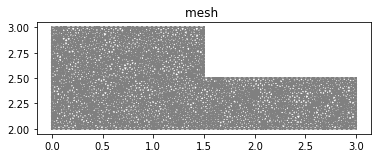

In [31]:

rectangle1=Rectangle(Point(X1,Y1),Point(X2,Y2))
rectangle2=Rectangle((Point(X3,Y3)),Point(X4,Y4))
mon_maillage=generate_mesh(rectangle1+rectangle2,nbre_pts)
plt.figure(1)
plot(mon_maillage,title="mesh ")


<p style ="color:red;"> Définition de l'espace de travail </p>

In [32]:
U=VectorElement("Lagrange",mon_maillage.ufl_cell(),2) # pour des raisons de stabilité la vitesse ne peux pas être modélisés par des elements finis P1
P=FiniteElement("Lagrange",mon_maillage.ufl_cell(),1)
W=FunctionSpace(mon_maillage,U*P)  # W.sub(0) pour les vitesses et W.sub(1) pour les pressions

<p style ="color:red;"> Condition aux limites </p>

In [33]:
tol=1e-14




def condition_gauche(x,on_boundary):
    return  on_boundary and (x[0]<X1+tol and (x[1]<3+tol or x[1]>2-tol))
   
def condition_droite(x,on_boundary):
    return on_boundary and (x[0]>X4-tol)

def condition_haut_bas(x,on_boundary):
    return on_boundary and ((x[1]<tol+2) or (x[1]>3-tol and (x[0]<1.5+tol or x[0]>-tol)) or (x[1]>2.5-tol and (x[0]<3+tol or x[0]>1.5-tol)))


#le gel entre dans le bec du flacon avec une pression p 

p_sortie=Constant(1e5)
bc_pression=DirichletBC(W.sub(1),p_sortie,condition_droite) #on applique la pression sur l'espace des pressions ici W(1)

#vitesse nulle sur les bords horizontaux et sur le bord vertical
v0=Expression(("0.0","0.0"),degree=2)

bcV0_haut_bas=DirichletBC(W.sub(0),v0,condition_haut_bas)



vitesse_entree=0.1
gel_entree=Expression((str(vitesse_entree),"0.0"),degree=2)
bc_gel_entree=DirichletBC(W.sub(0),gel_entree,condition_gauche)

bc_total=[bc_pression,bcV0_haut_bas,bc_gel_entree]

<p style ="color:red;"> Formulation variationnelle  </p>


In [34]:
u,p=TrialFunctions(W)
v,q= TestFunctions(W)
f=Constant((0.0,0.0))
a= inner(grad(u),grad(v))*dx+1/nu*inner(v,grad(p))*dx+1/nu*q*div(u)*dx
l=1/nu*inner(f,v)*dx


<p style ="color:red;"> Résolution du système  </p>

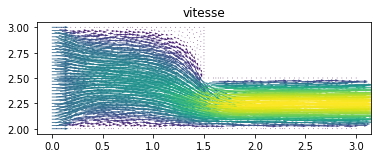

In [35]:
u=Function(W)
solve(a==l,u,bc_total)
u_f=u.split()[0]

plot(u_f,title="vitesse",scale=2)


On voit ici un écoulement normal du gel dans le bec distributeur avec une forte accélération de la vitesse du fluide dans le goulot. Ceci correspond à l'effet Venturi observé en mécanique des fluides et notre fluide à donc ici un comportement assez classique sans perturbation de l'écoulement par un quelconque dépot. On remarque bien sur la simulation précédente que la vitesse du fluide est nulle sur les bords et donc logiquement plus importante sur la ligne médiane de notre écoulement.

### Prise en compte d'un paramètre aléatoire 

In [36]:
Ox1=2.7
Oy1=2

Ox2=2.9
Oy2=random.uniform(2,2.5)

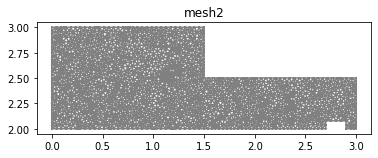

In [37]:
rectangle1=Rectangle(Point(X1,Y1),Point(X2,Y2))
rectangle2=Rectangle((Point(X3,Y3)),Point(X4,Y4))
obstacle= Rectangle(Point(Ox1,Oy1),Point(Ox2,Oy2))
mon_maillage2=generate_mesh(rectangle1+rectangle2-obstacle,nbre_pts)
plt.figure(2)
plot(mon_maillage2,title="mesh2")


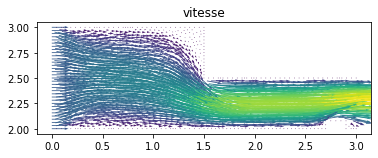

In [38]:
U=VectorElement("Lagrange",mon_maillage2.ufl_cell(),2) # pour des raisons de stabilité la vitesse ne peux pas être modélisés par des elements finis P1
P=FiniteElement("Lagrange",mon_maillage2.ufl_cell(),1)
W=FunctionSpace(mon_maillage2,U*P)  # W.sub(0) pour les vitesses et W.sub(1) pour les pressions

tol=1e-14


def condition_gauche(x,on_boundary):
    return  on_boundary and (x[0]<X1+tol)
   
def condition_droite(x,on_boundary):
    return on_boundary and (x[0]>X4-tol)

def condition_haut_bas(x,on_boundary):
    return on_boundary and ((x[1]<tol+2) or (x[1]>3-tol and (x[0]<1.5+tol or x[0]>-tol)) or (x[1]>2.5-tol and (x[0]<3+tol or x[0]>1.5-tol)))

def condition_obstacle(x,on_boundary):
    return on_boundary and x[0]<Ox2+tol and x[0]>Ox1-tol and x[1]<Oy2+tol and x[1]>Oy1-tol

#le gel entre dans le bec du flacon avec une pression p 

p_sortie=Constant(1e5)
bc_pression=DirichletBC(W.sub(1),p_sortie,condition_droite) #on applique la pression sur l'espace des pressions ici W(1)

#vitesse nulle sur les bords horizontaux et sur le bord vertical et sur l'obstacle
v0=Expression(("0.0","0.0"),degree=2)

bcV0_haut_bas=DirichletBC(W.sub(0),v0,condition_haut_bas)
bc_obstacle=DirichletBC(W.sub(0),v0,condition_obstacle)



#vecteur vitesse pour le gel en sortie 

vitesse_entree=0.1
gel_sortie=Expression((str(vitesse_entree),"0.0"),degree=2)
bc_gel_entree=DirichletBC(W.sub(0),gel_sortie,condition_gauche)

bc_total=[bc_pression,bcV0_haut_bas,bc_obstacle,bc_gel_entree]
u,p=TrialFunctions(W)
v,q= TestFunctions(W)
f=Constant((0.0,0.0))
a= inner(grad(u),grad(v))*dx+1/nu*inner(v,grad(p))*dx+1/nu*q*div(u)*dx
l=1/nu*inner(f,v)*dx

u=Function(W)
solve(a==l,u,bc_total)
u_f=u.split()[0]
p=u.split()[1]

plot(u_f,title="vitesse",scale=2)



Dans le cas avec un dépôt solide de taille variable( composante aléatoire ici ou on fait varier la position et donc la taille du dépôt solide), on remarque la perturbation de notre écoulement et des vecteurs vitesses qui partent dans une direction  " non colinéaire" à l'écoulement (je vous conseille de lancer le code plusieurs fois afin de voir les changements liés à la taille du dépôt solide). Le comportement de notre fluide a donc été perturbé et ceci peut expliquer la projection de fluide dans des directions non souhaitées. 
On pourrait ensuite s'intéresser dans un autre projet à la force exercée sur ce dépôt solide et à son évolution au fur et à mesure des utilisations ( evacuation de ce dernier peut être) et donc déterminer le moment où l'écoulement redevient "normal" c'est à dire sans projection. Pour avoir fait l'expérience de mon côté, le dépot solide s'évacuait avec environ 5 utilisations de gel hydroalcoolique(Ce gel ne fut pas gâché pour l'expérience). De plus un  début de dépôt solide pouvait être observé dans ma bouteille en environ 3h30. Evidemment toutes ces données peuvent varier en fonction du type de gel, sa composition, les conditions de température et de pression et la force exercée sur la bouteille pour faire sortir le gel. 

### Bibliographie:

https://fr.wikipedia.org/wiki/Écoulement_de_Stokes 

http://www.iecl.univ-lorraine.fr/~Jean-Francois.Scheid/Enseignement/polyNS2017_18.pdf

https://courses.ex-machina.ma/downloads/gm-2/s7/M_E_F/EFM_Stokes.pdf

https://fenicsproject.org/olddocs/dolfin/1.3.0/python/demo/documented/stokes-iterative/python/documentation.html 
